In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import os

In [2]:
device = torch.device('cuda:0')
if device.type == 'cuda':
            torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Helper functions

## Plot function

In [3]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    
    num_classes = len(set(labels)) # Calculate the number of classes
    palette = np.array(sns.color_palette("hls", num_classes)) # Choosing color

    ## Create a seaborn scatter plot ##
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    ## ---------------------------- ##
    
    ## Add label on top of each cluster ##
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    ## ---------------------------- ##    
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig('./plot/' +str(subtitle))

## Triplet loss + mining functions 

In [4]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    embeddings = torch.squeeze(embeddings,1)  # shape=(batch_size, features, 1)
    dot_product = torch.matmul(embeddings, torch.transpose(embeddings,0,1)) # shape=(batch_size, batch_size)
    
    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)
    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = torch.unsqueeze(square_norm, 1) - 2.0 * dot_product + torch.unsqueeze(square_norm, 0)
    
    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.max(distances, torch.Tensor([0.0]))
    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = (distances == 0.0).float()
        distances = distances + mask * 1e-16
        distances = torch.sqrt(distances)
        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)
    # return distances matrix (batch X batch)
    return distances


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)
    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = torch.unsqueeze(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = torch.unsqueeze(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = mask.float()
    
    triplet_loss = mask*triplet_loss

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = torch.max(triplet_loss, torch.Tensor([0.0]))

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = (triplet_loss > 1e-16).float()
    
    num_positive_triplets = torch.sum(valid_triplets)
    
    num_valid_triplets = torch.sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = torch.sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, num_positive_triplets, num_valid_triplets

def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: torch.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = torch.eye(labels.size()[0]).type(torch.ByteTensor) # make a index in Bool
    indices_not_equal = -(indices_equal-1) # flip booleans
    i_not_equal_j = torch.unsqueeze(indices_not_equal, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_equal, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_equal, 0)

    distinct_indices = (i_not_equal_j & i_not_equal_k) & j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = (torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)

    valid_labels = (i_equal_j & -(i_equal_k-1))
    # Combine the two masks
    mask = (distinct_indices.cuda() & valid_labels)

    return mask

# Simple Neural Network

In [5]:
class TNN(nn.Module):
    def __init__(self, input_size):
        super(TNN, self).__init__()
        m1_out = 20
        m2_out = 10
        m3_out = 2
        self.m1 = nn.Linear(input_size, m1_out)
        self.m2 = nn.Linear(m1_out, m2_out)
        self.m3 = nn.Linear(m2_out, m3_out)
        
    def forward(self, x):
        x = F.relu(self.m1(x))
        x = F.relu(self.m2(x))
        x = self.m3(x)
        return x

In [6]:
model = TNN(10)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Toy dataset

In [7]:
ar_x, ar_y = make_blobs(1000, 10, 10, cluster_std=5, shuffle=False, random_state=0) # creating artifical data

# Converting all numpy array to Pytorch array

In [10]:
x_train = torch.Tensor(ar_x)
y_train = torch.Tensor(ar_y)
trainset = torch.utils.data.TensorDataset(x_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=750,
                                          shuffle=True, num_workers=0)

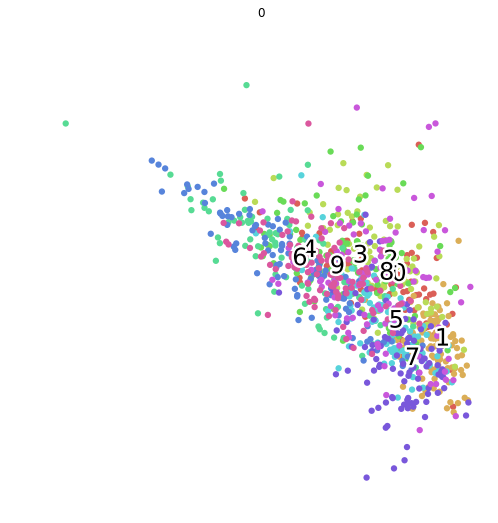

In [11]:
outputs = model(x_train)
outputs = outputs.cpu().detach().numpy()
scatter(outputs, ar_y, '0')

At epoches = 0, i = 0, loss = 0.9436031579971313, trainable_triplet = 22452596.0, total_triplets = 37504488.0
epoch_loss = 0.0020623656113942465
At epoches = 1, i = 0, loss = 0.6040303111076355, trainable_triplet = 19359704.0, total_triplets = 37534064.0
epoch_loss = 0.00151411771774292
At epoches = 2, i = 0, loss = 0.5734019875526428, trainable_triplet = 15690791.0, total_triplets = 37552392.0
epoch_loss = 0.0016101523240407308
At epoches = 3, i = 0, loss = 0.570882260799408, trainable_triplet = 12985164.0, total_triplets = 37562380.0
epoch_loss = 0.001574541966120402
At epoches = 4, i = 0, loss = 0.5588345527648926, trainable_triplet = 11194174.0, total_triplets = 37571488.0
epoch_loss = 0.0014808213710784913
At epoches = 5, i = 0, loss = 0.5499334335327148, trainable_triplet = 9785504.0, total_triplets = 37515924.0
epoch_loss = 0.001462964614232381
At epoches = 6, i = 0, loss = 0.5593041181564331, trainable_triplet = 9594209.0, total_triplets = 37496156.0
epoch_loss = 0.001402236064

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


At epoches = 21, i = 0, loss = 0.5241166949272156, trainable_triplet = 5659030.0, total_triplets = 37543064.0
epoch_loss = 0.0013541355927785238
At epoches = 22, i = 0, loss = 0.49416181445121765, trainable_triplet = 5923107.0, total_triplets = 37535224.0
epoch_loss = 0.0013426475922266642
At epoches = 23, i = 0, loss = 0.48293590545654297, trainable_triplet = 6239268.0, total_triplets = 37541232.0
epoch_loss = 0.0012661660114924114
At epoches = 24, i = 0, loss = 0.4803437888622284, trainable_triplet = 5685000.0, total_triplets = 37556880.0
epoch_loss = 0.001258243958155314
At epoches = 25, i = 0, loss = 0.46647417545318604, trainable_triplet = 5524049.0, total_triplets = 37601816.0
epoch_loss = 0.0013420011997222901
At epoches = 26, i = 0, loss = 0.48903337121009827, trainable_triplet = 5380005.0, total_triplets = 37553020.0
epoch_loss = 0.001332549770673116
At epoches = 27, i = 0, loss = 0.46153414249420166, trainable_triplet = 5240173.0, total_triplets = 37521160.0
epoch_loss = 0.00

At epoches = 78, i = 0, loss = 0.5000783801078796, trainable_triplet = 2727770.0, total_triplets = 37523228.0
epoch_loss = 0.0013048075040181478
At epoches = 79, i = 0, loss = 0.4891605079174042, trainable_triplet = 2636863.0, total_triplets = 37534032.0
epoch_loss = 0.001332059105237325
At epoches = 80, i = 0, loss = 0.478046715259552, trainable_triplet = 2685847.0, total_triplets = 37556496.0
epoch_loss = 0.0013576687971750894
At epoches = 81, i = 0, loss = 0.5008925199508667, trainable_triplet = 2774447.0, total_triplets = 37553916.0
epoch_loss = 0.0012509899139404297
At epoches = 82, i = 0, loss = 0.4607465863227844, trainable_triplet = 2593765.0, total_triplets = 37548088.0
epoch_loss = 0.001383263905843099
At epoches = 83, i = 0, loss = 0.48164358735084534, trainable_triplet = 2541430.0, total_triplets = 37556516.0
epoch_loss = 0.0012739504178365072
At epoches = 84, i = 0, loss = 0.4799419641494751, trainable_triplet = 2636151.0, total_triplets = 37524400.0
epoch_loss = 0.0012695

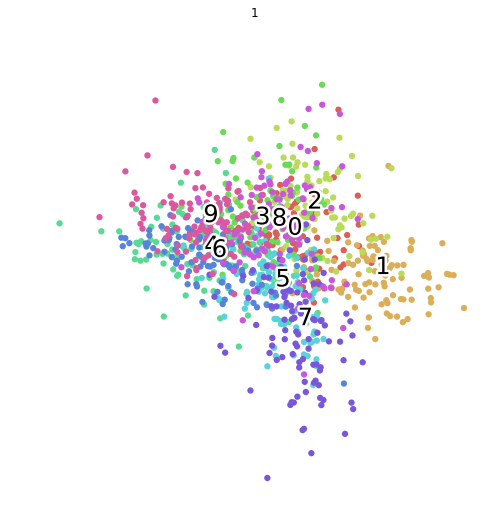

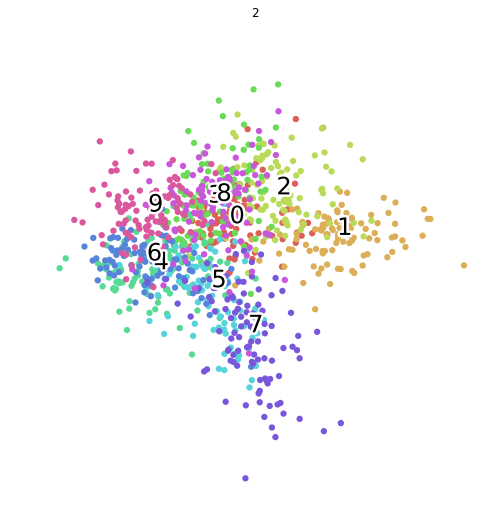

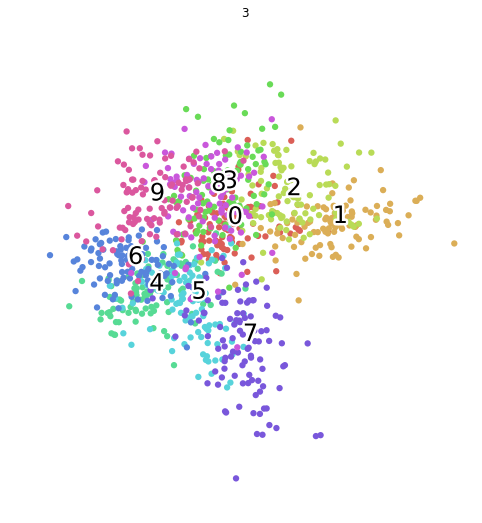

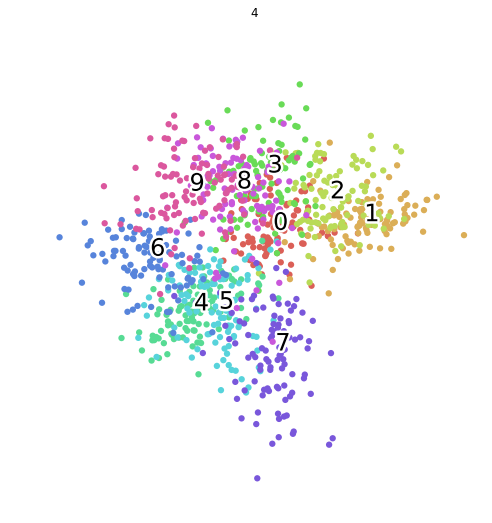

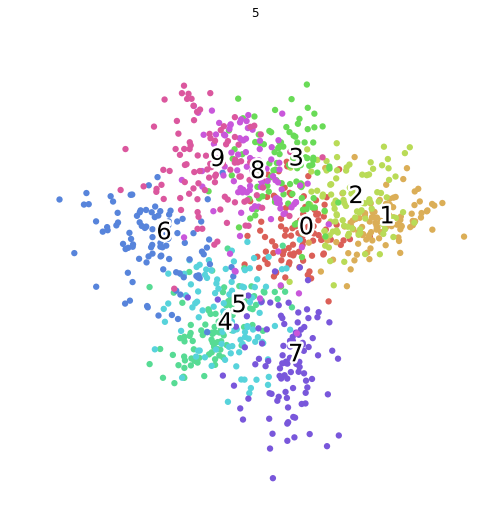

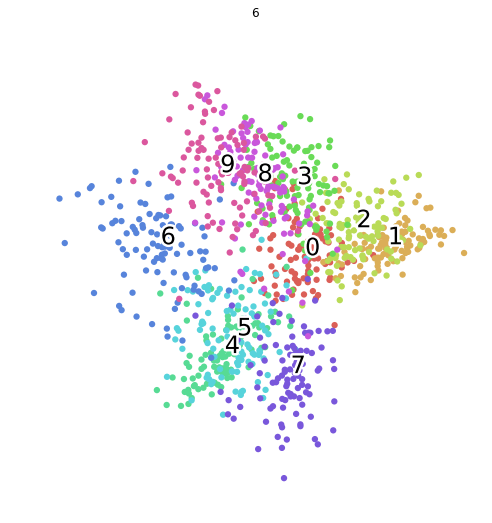

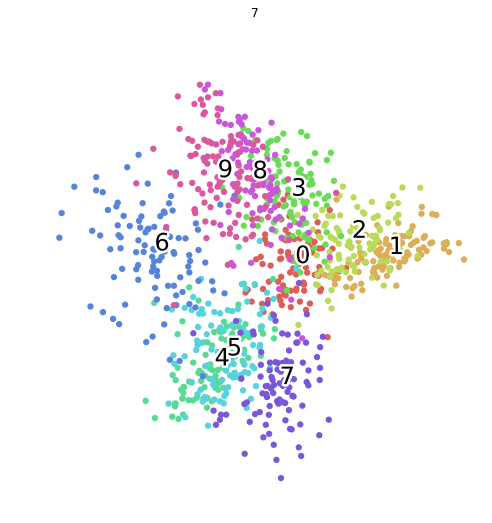

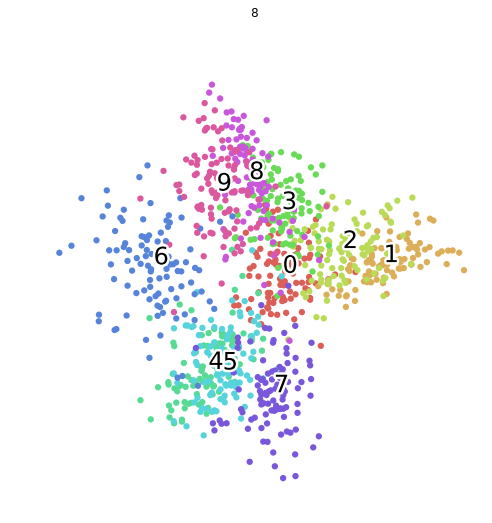

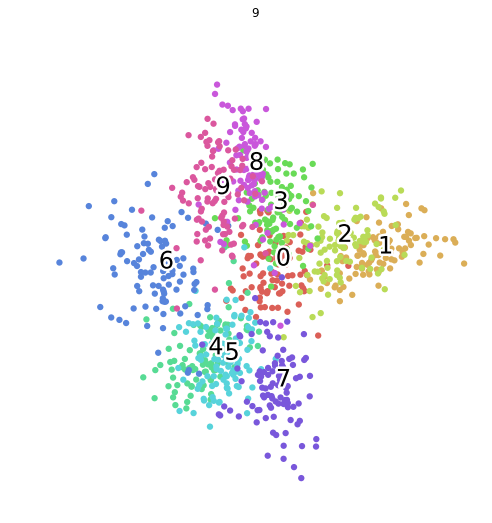

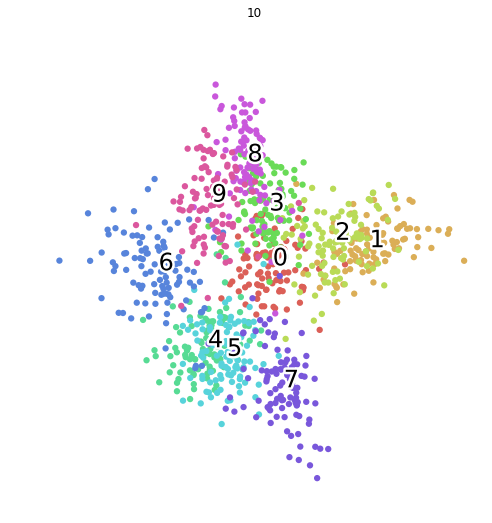

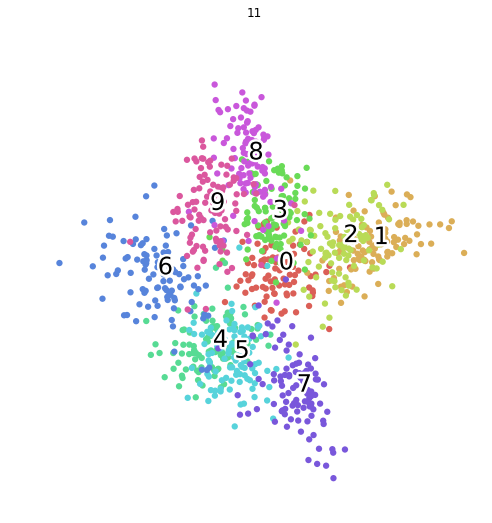

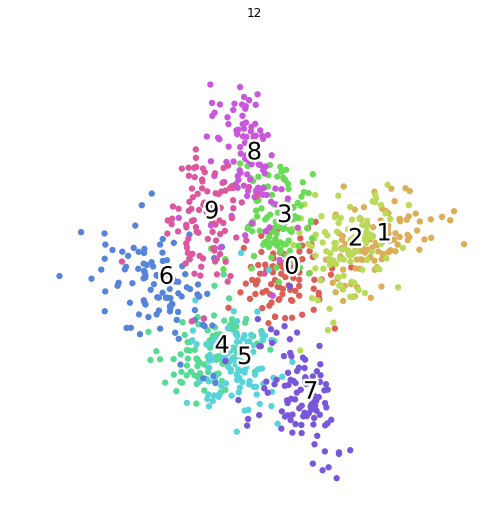

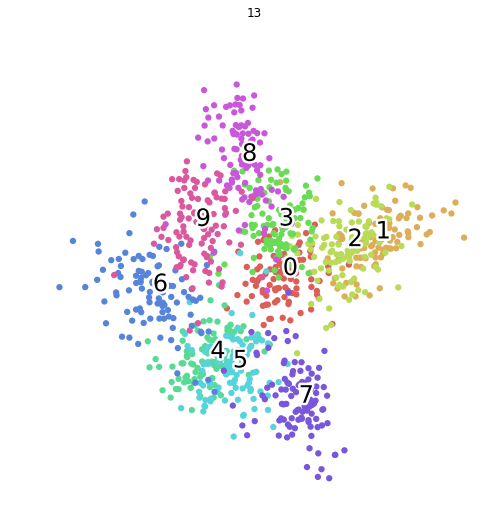

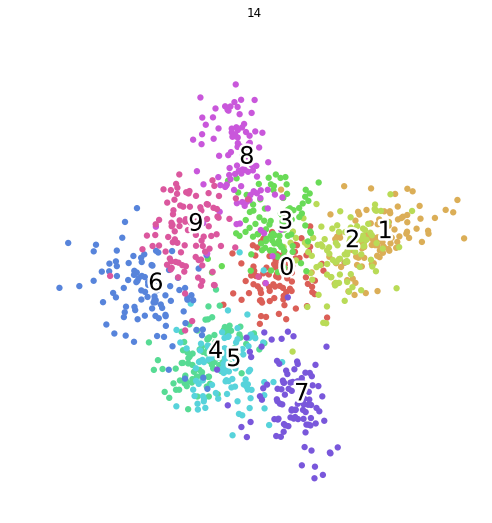

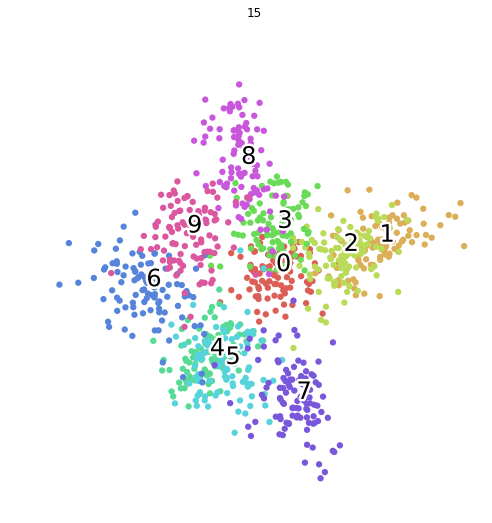

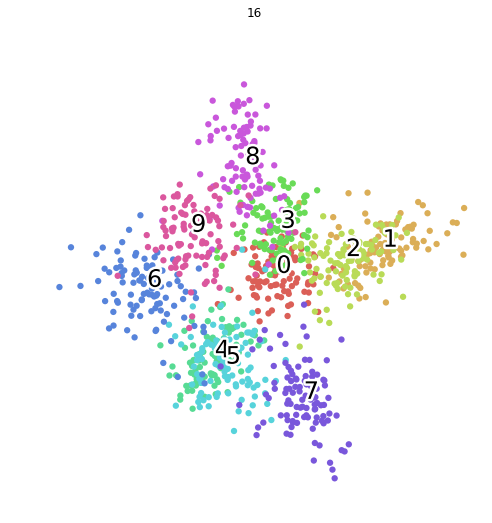

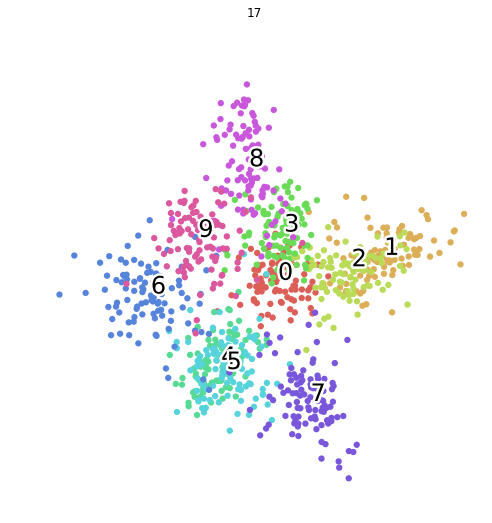

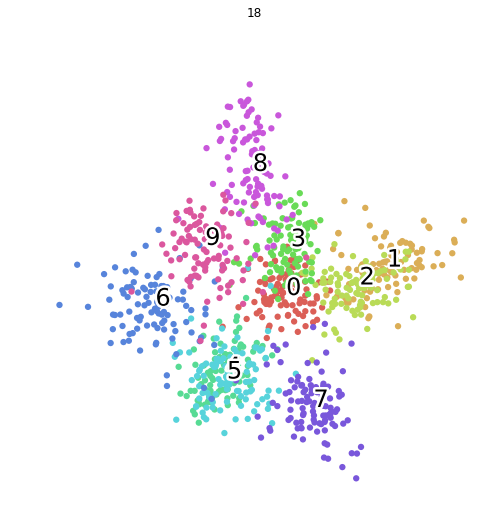

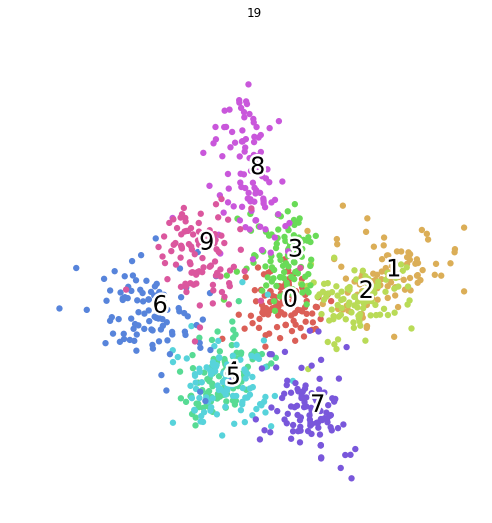

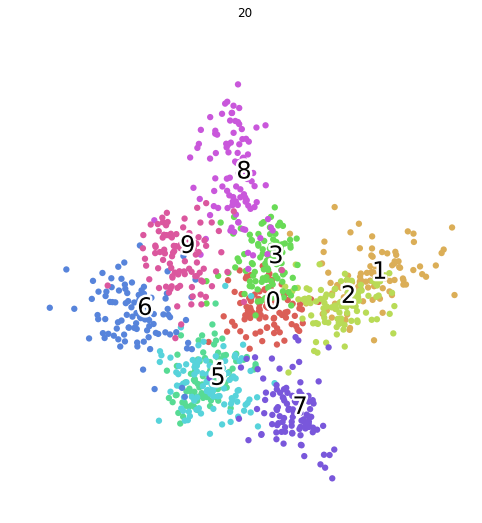

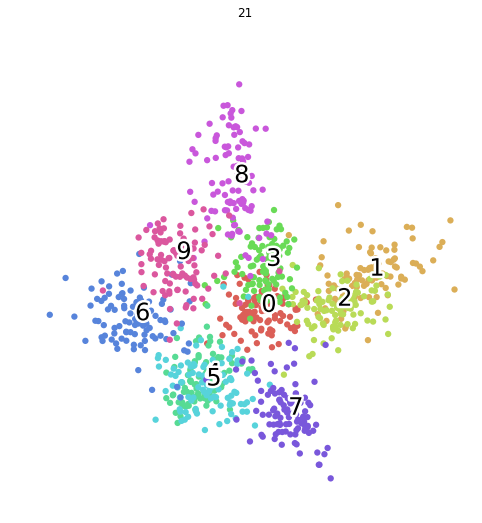

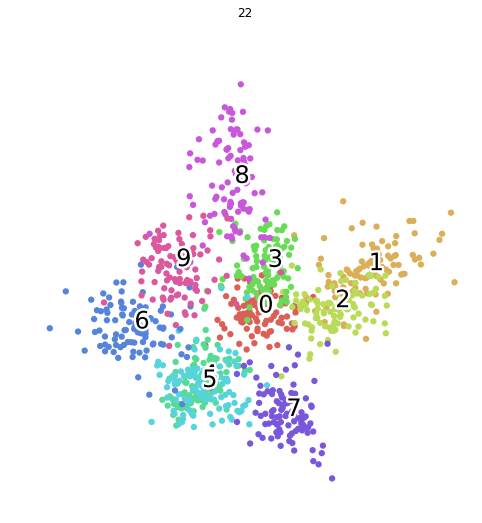

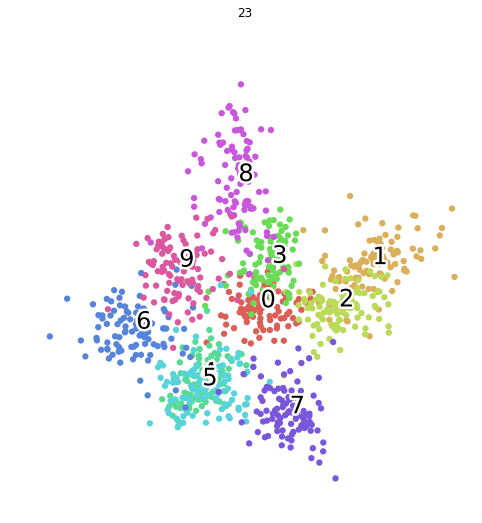

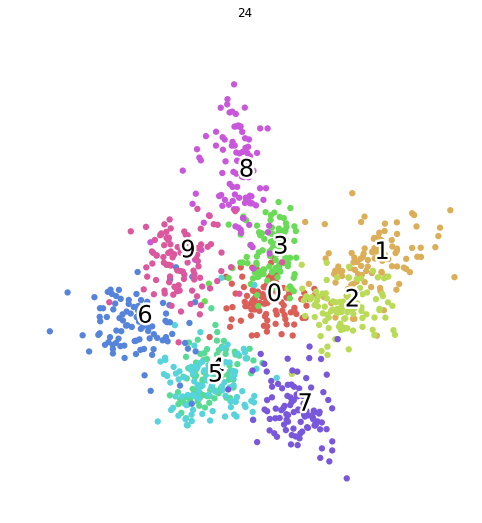

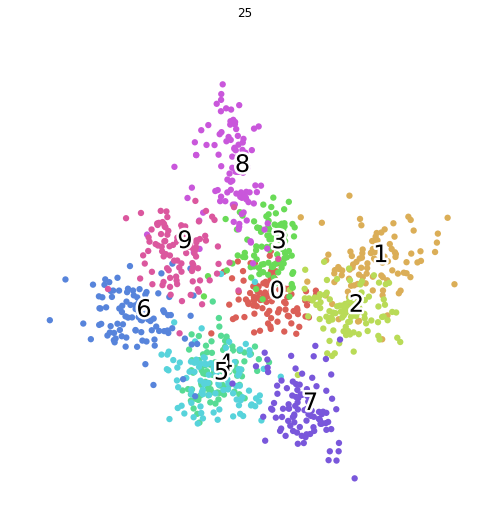

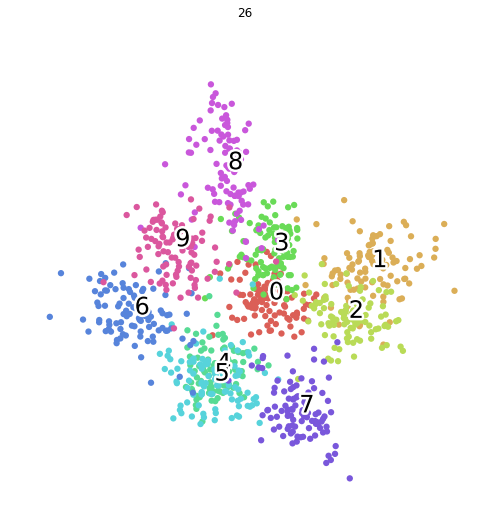

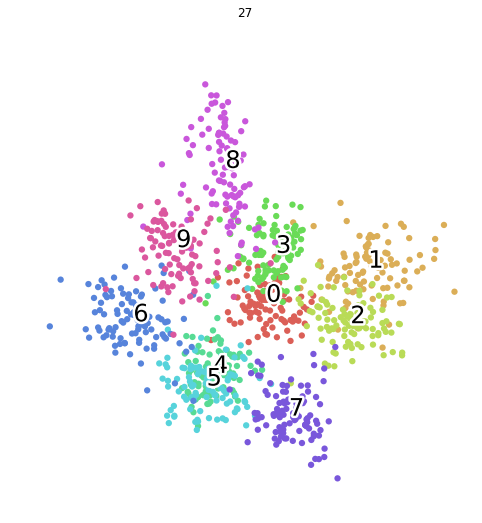

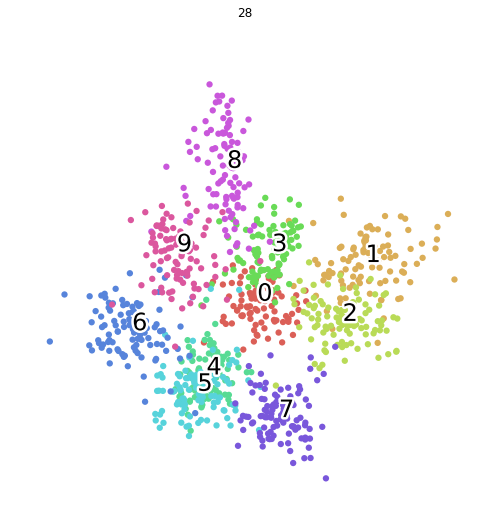

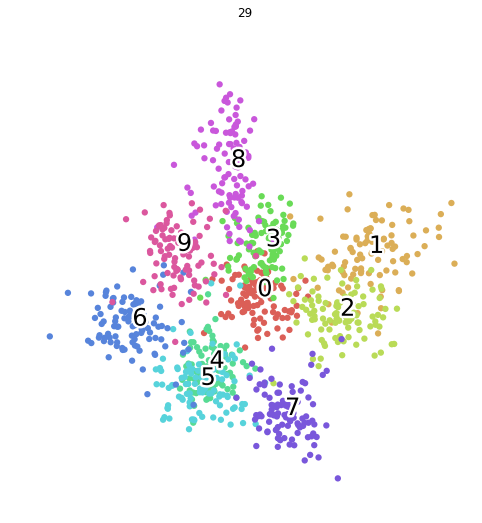

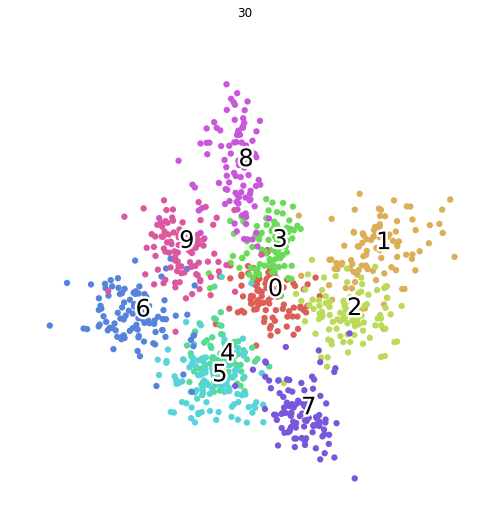

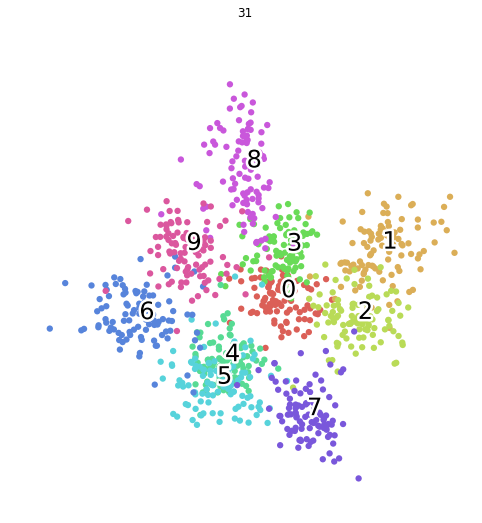

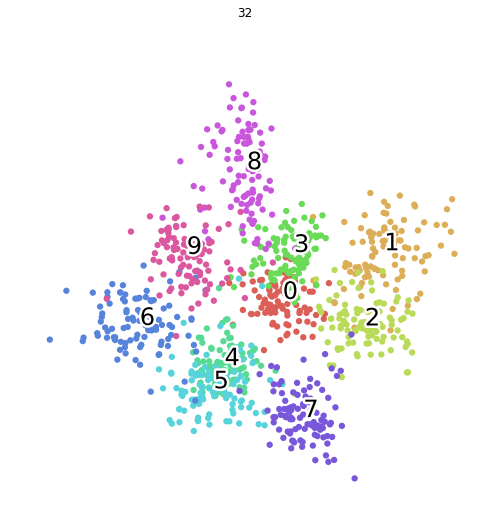

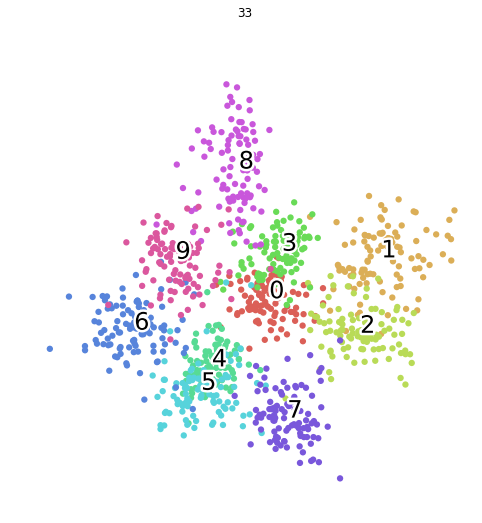

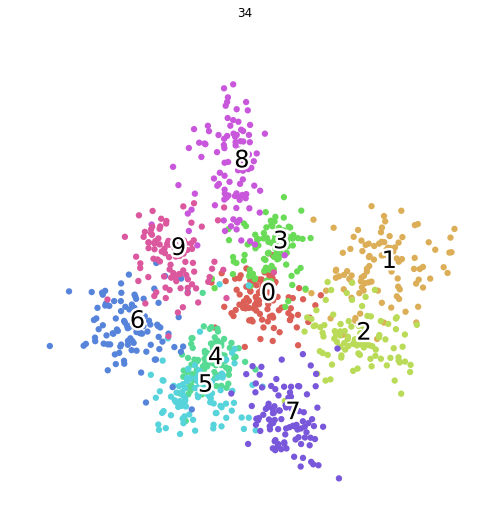

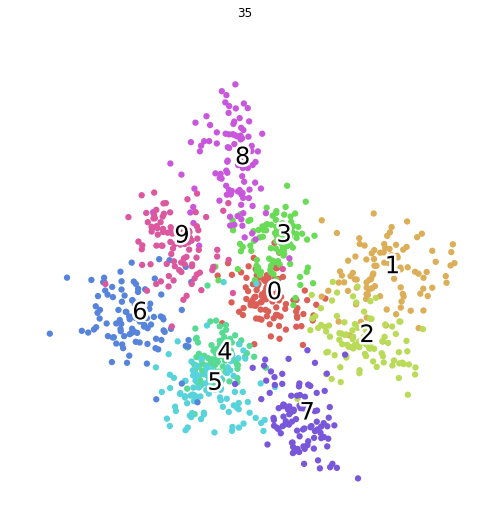

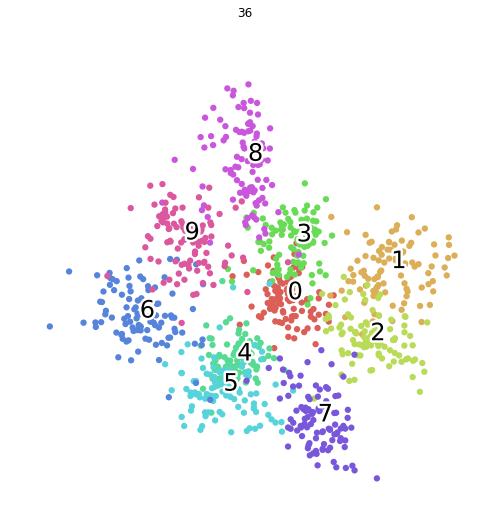

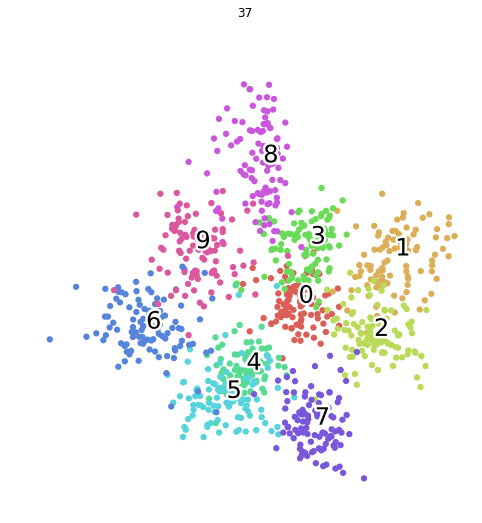

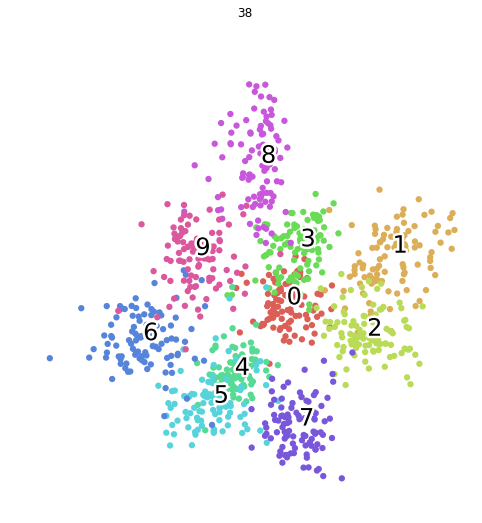

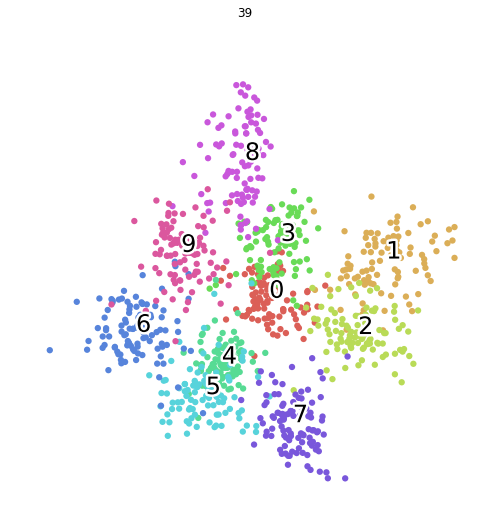

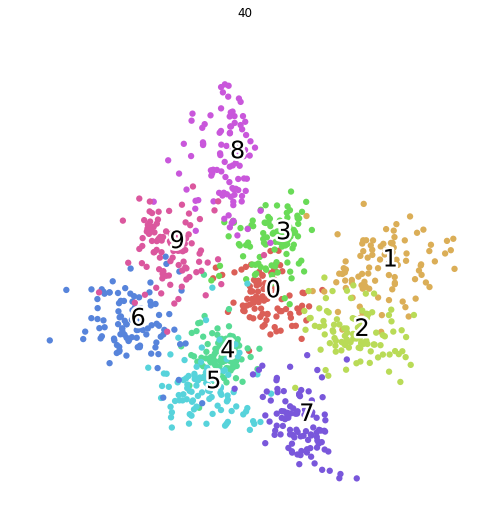

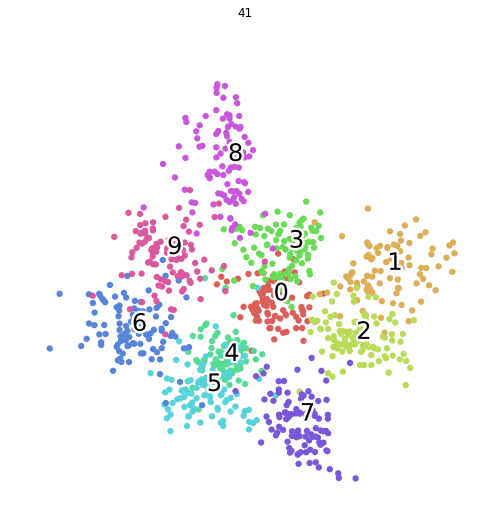

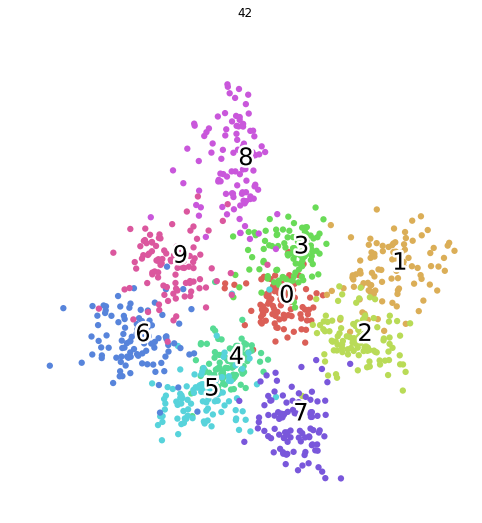

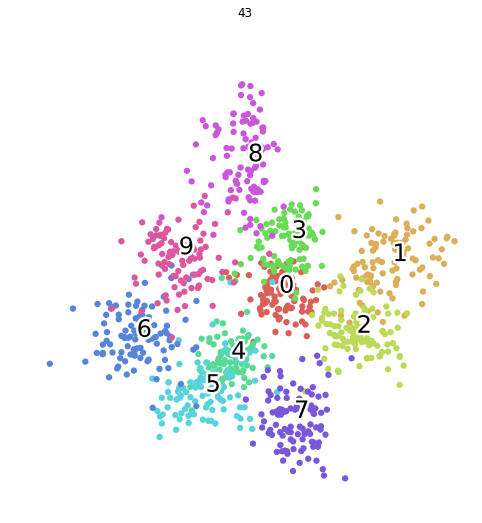

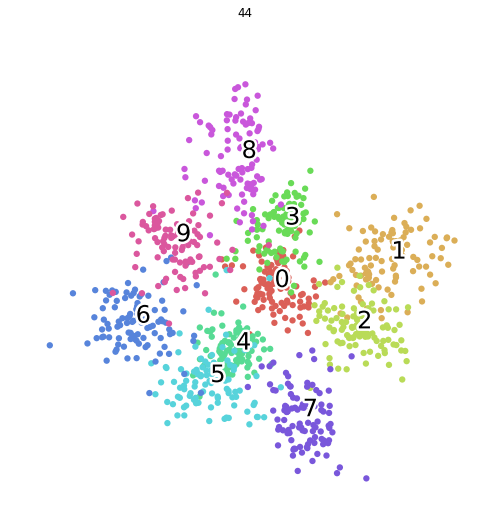

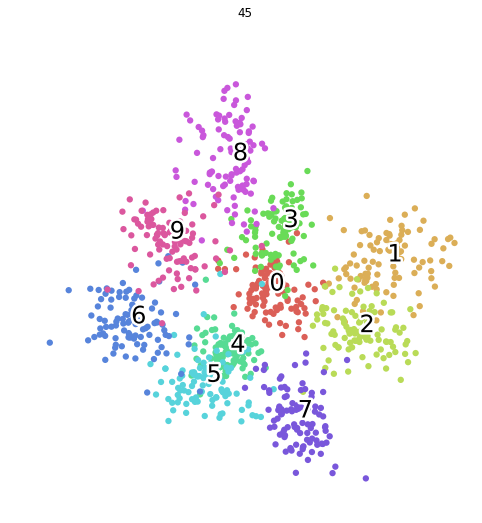

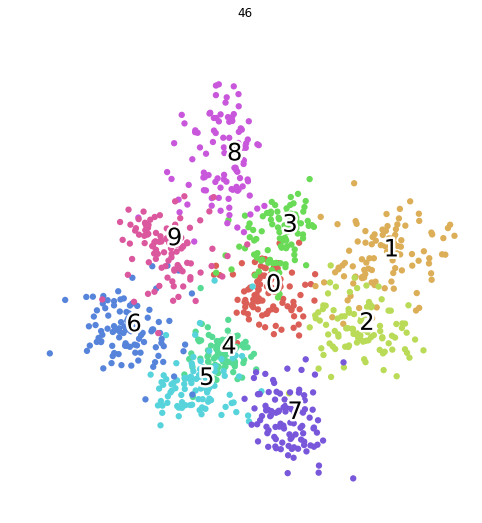

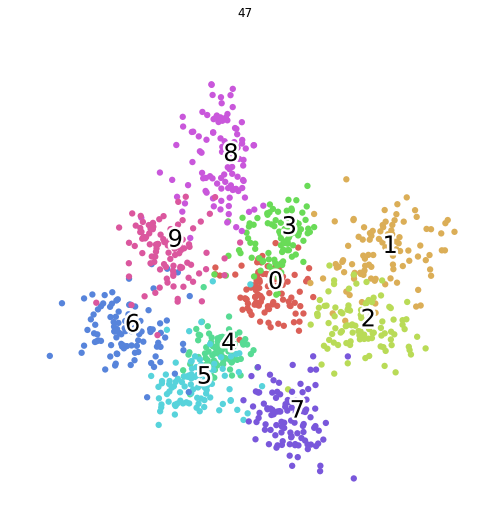

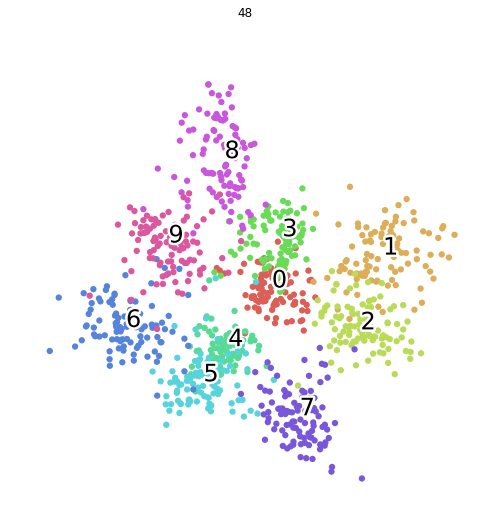

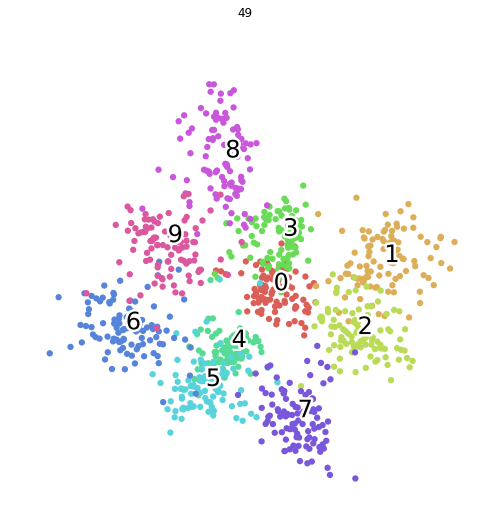

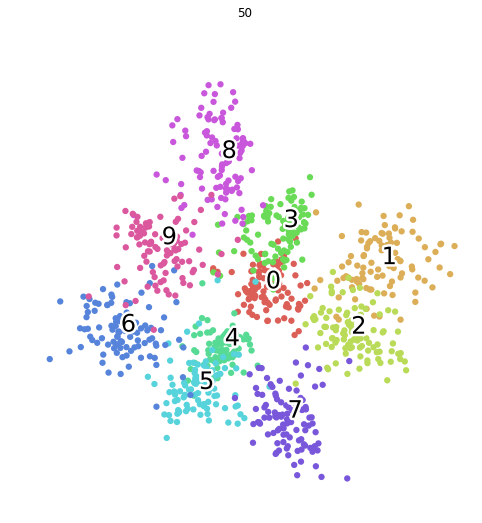

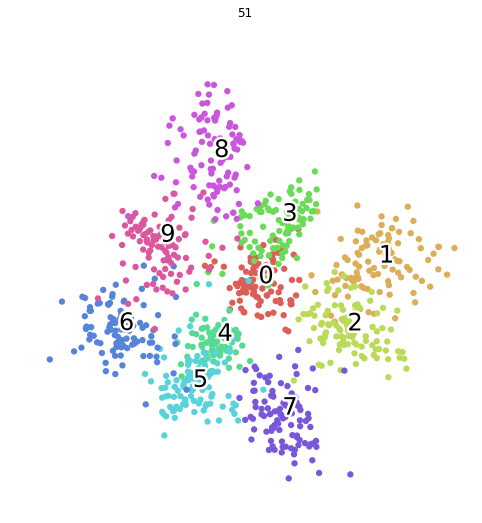

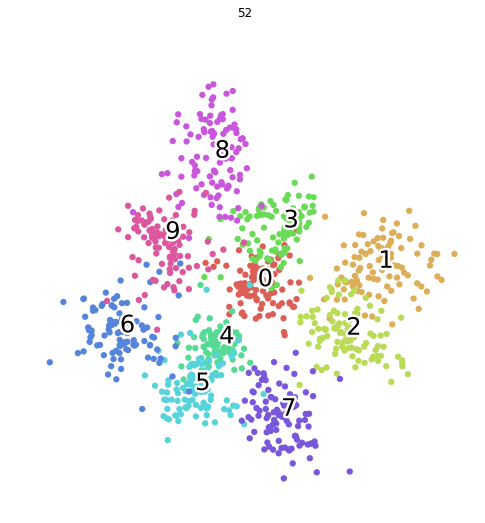

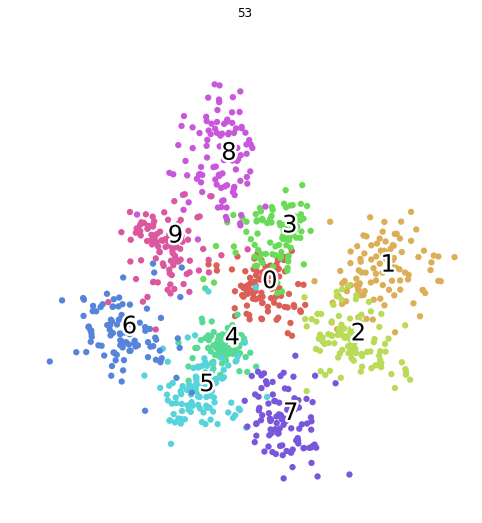

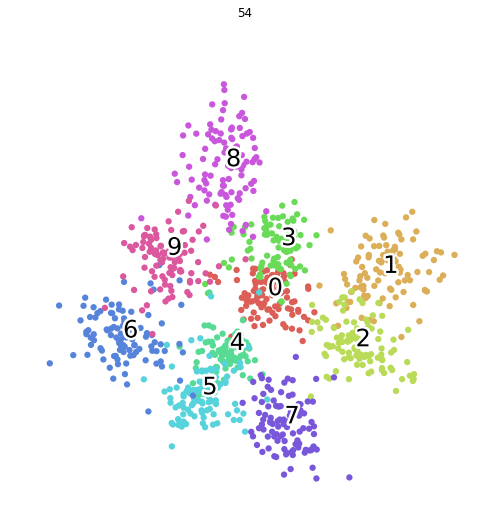

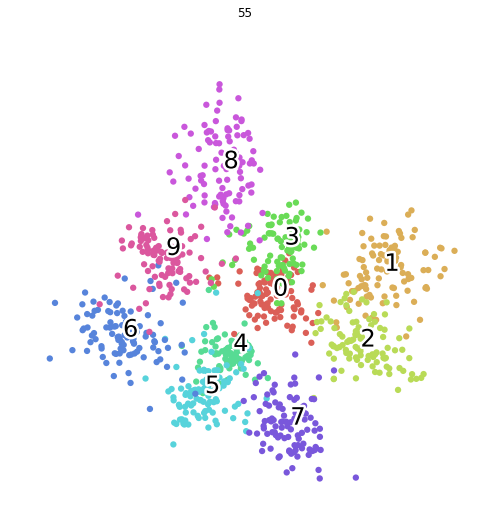

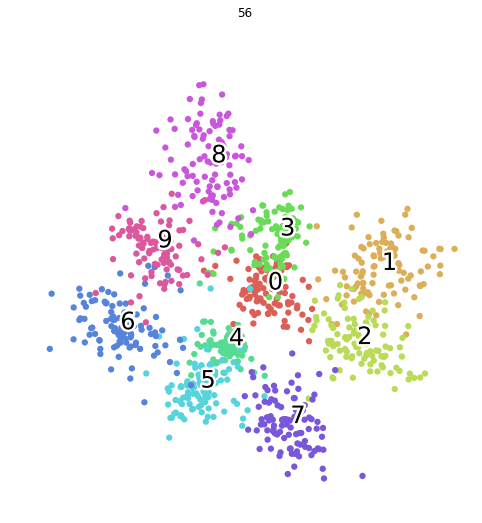

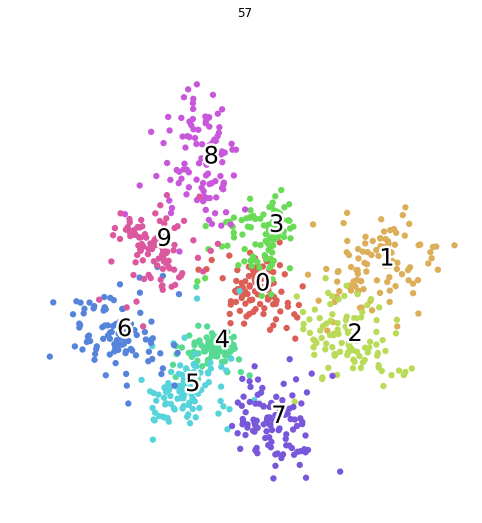

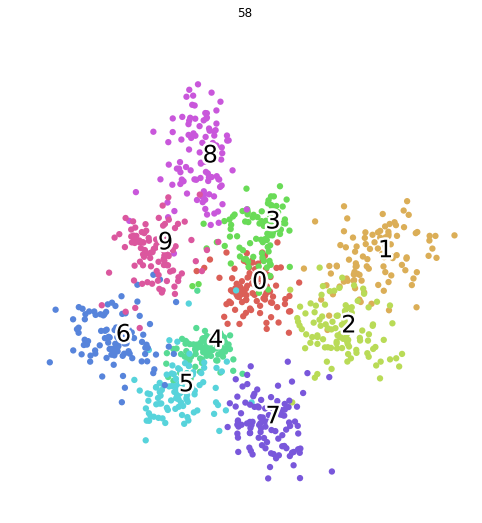

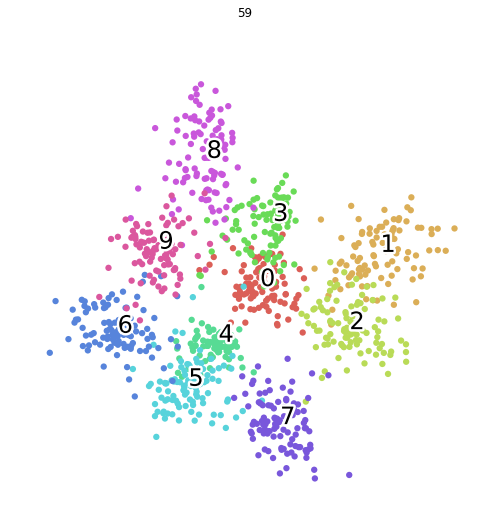

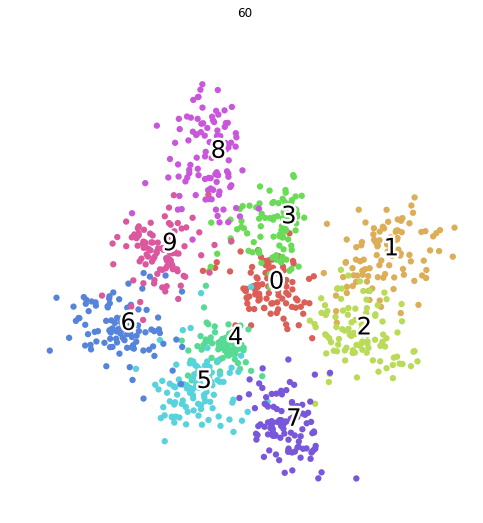

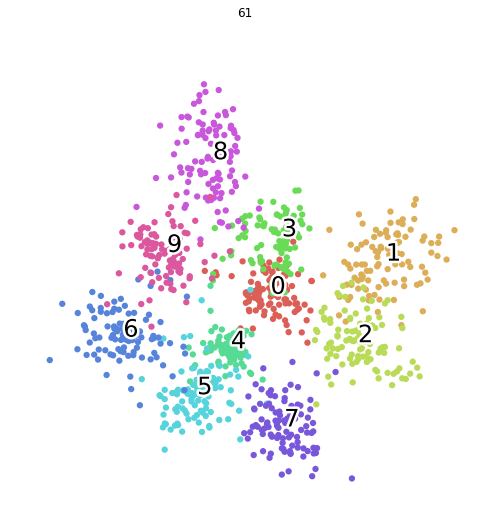

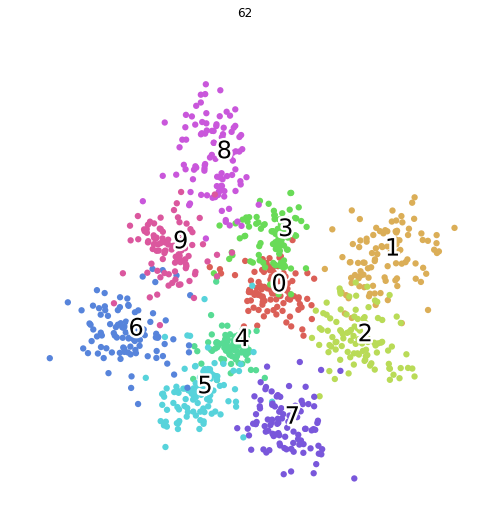

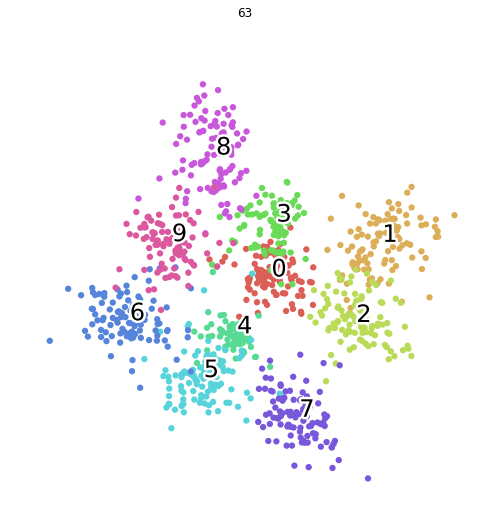

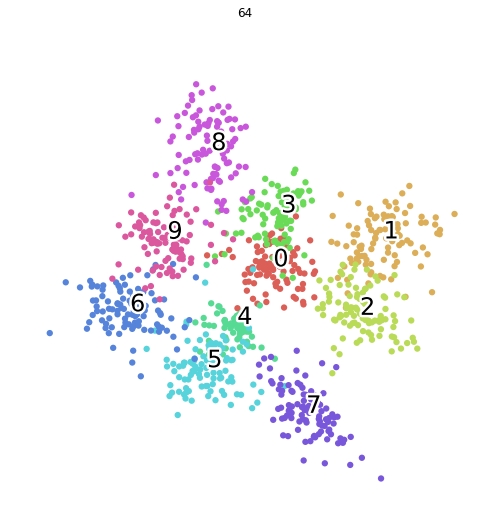

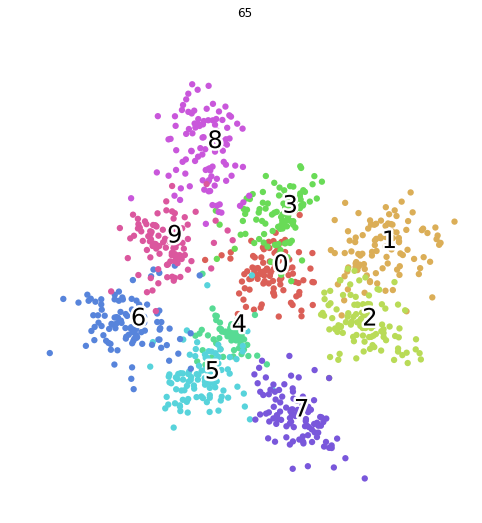

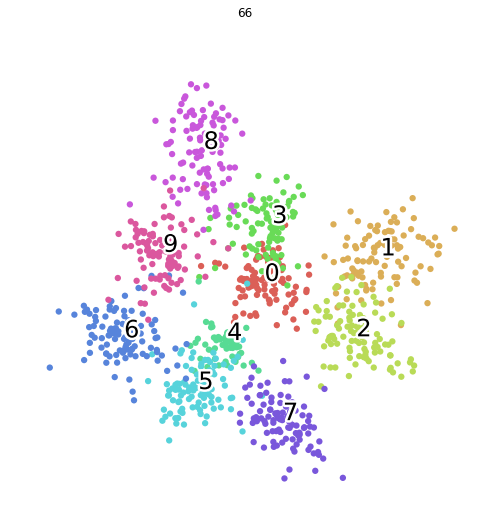

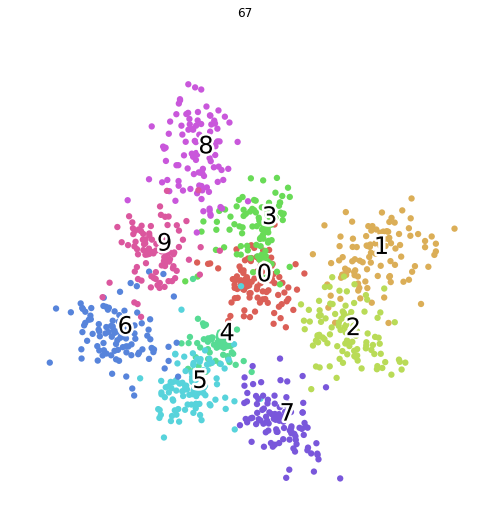

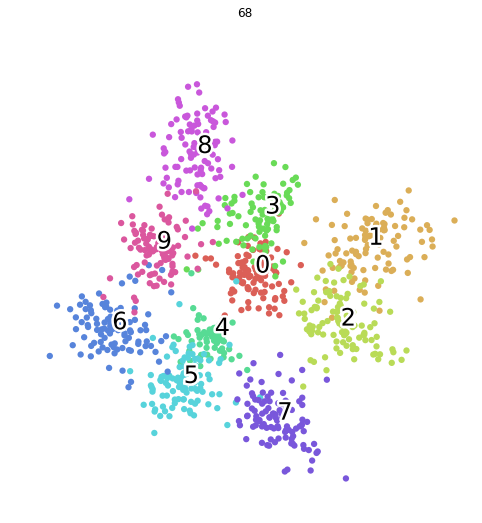

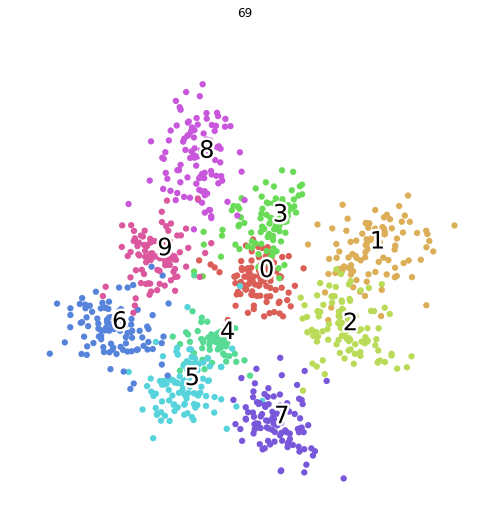

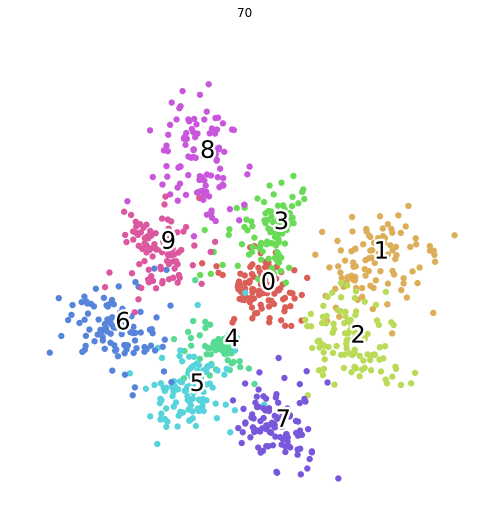

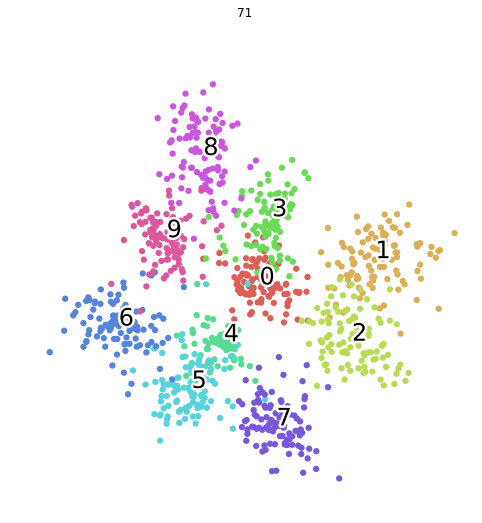

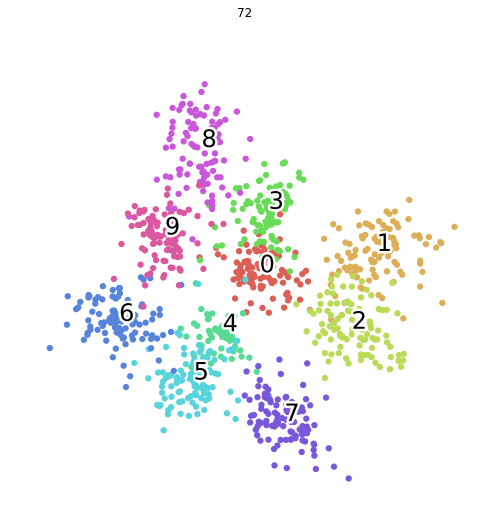

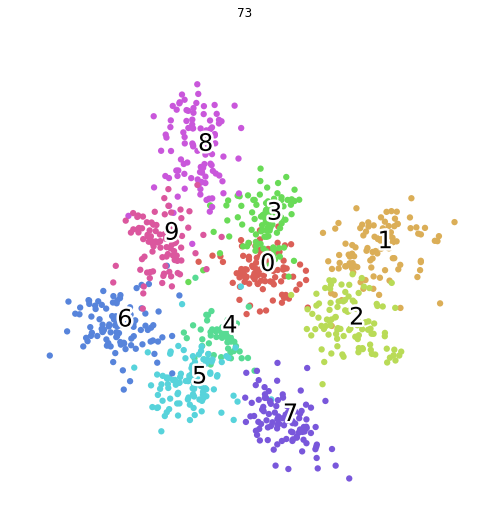

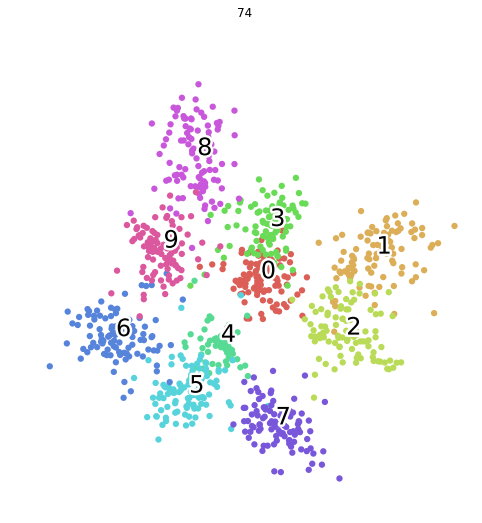

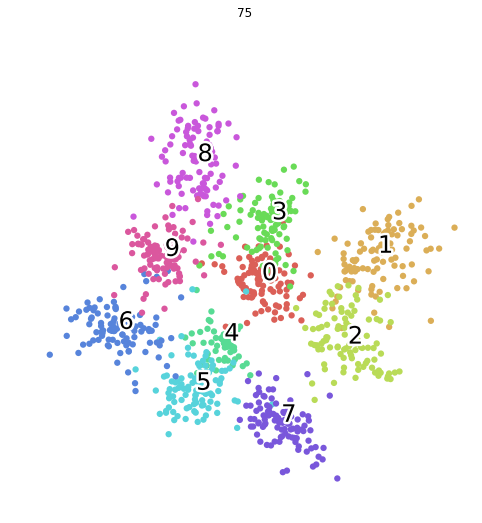

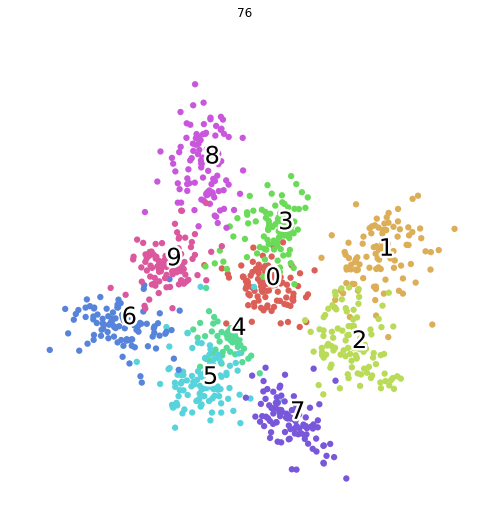

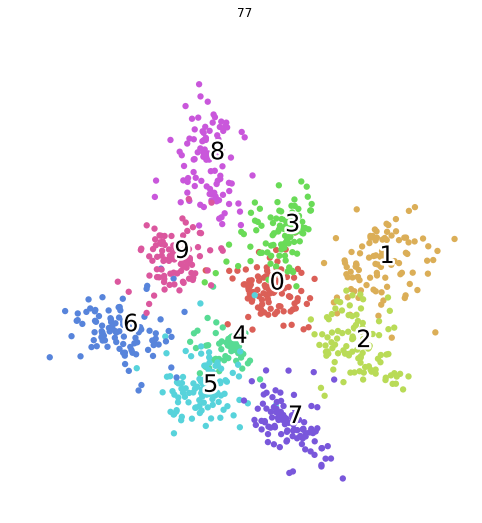

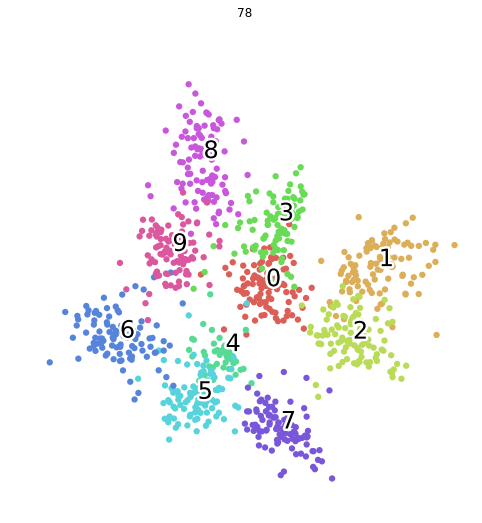

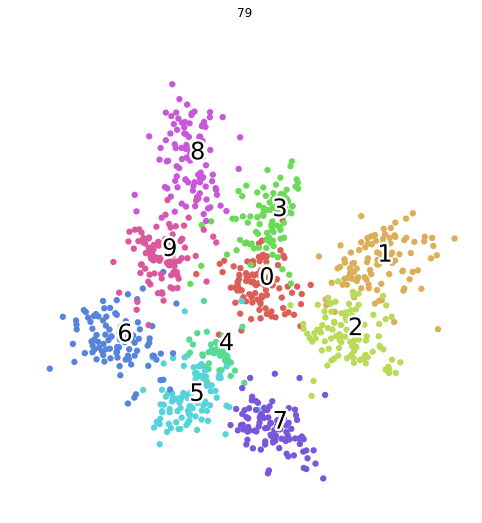

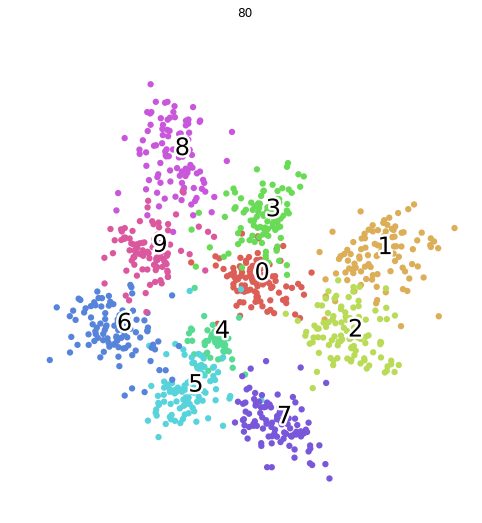

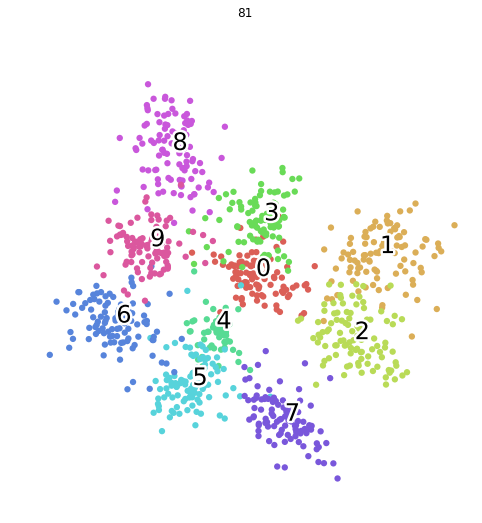

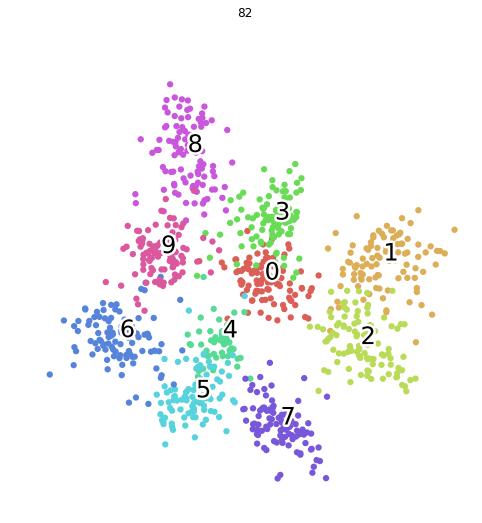

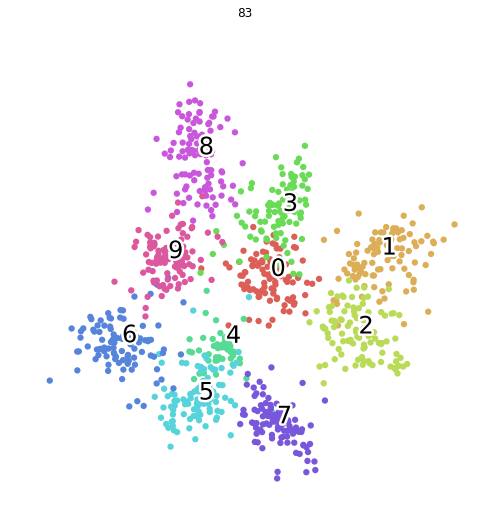

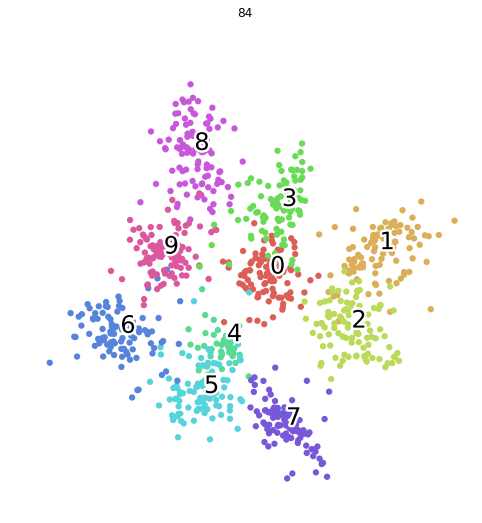

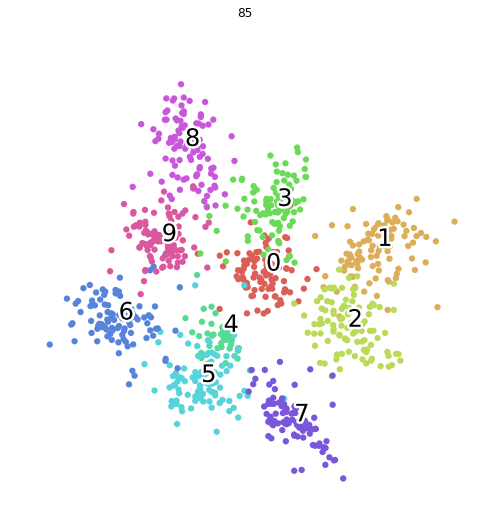

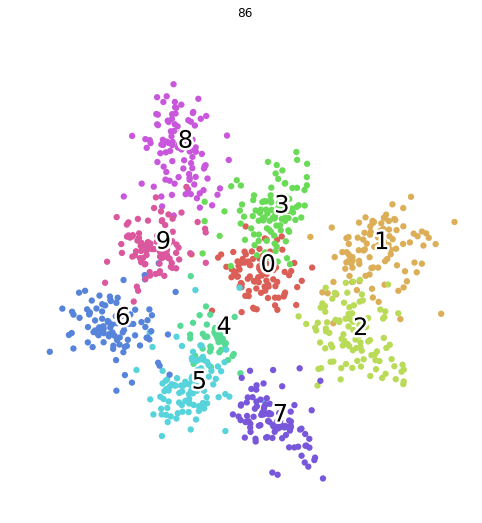

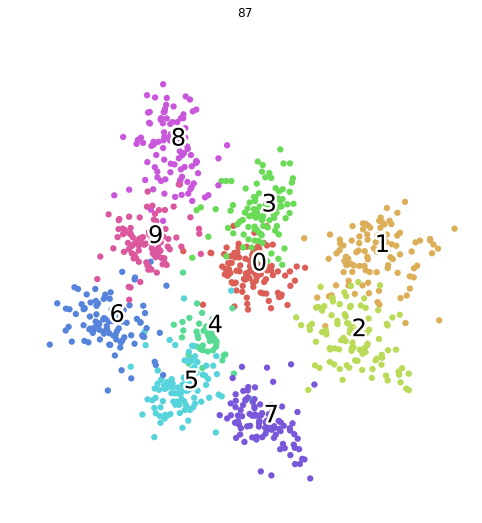

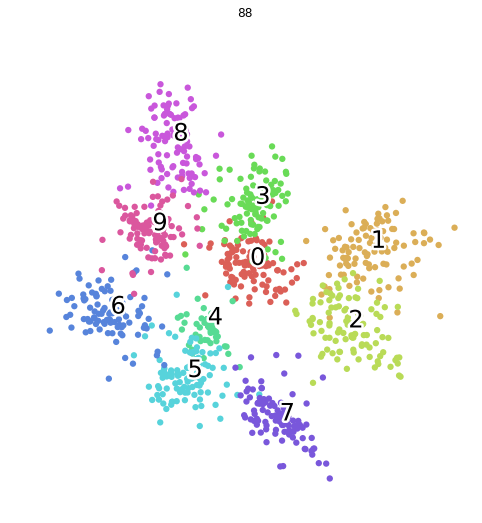

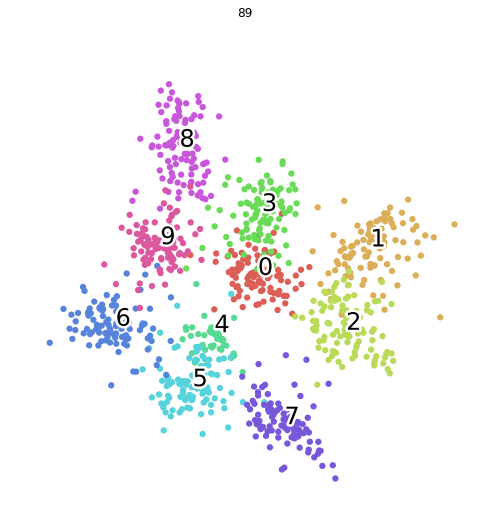

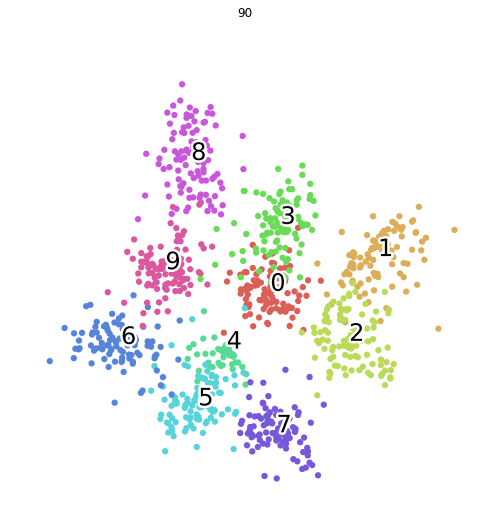

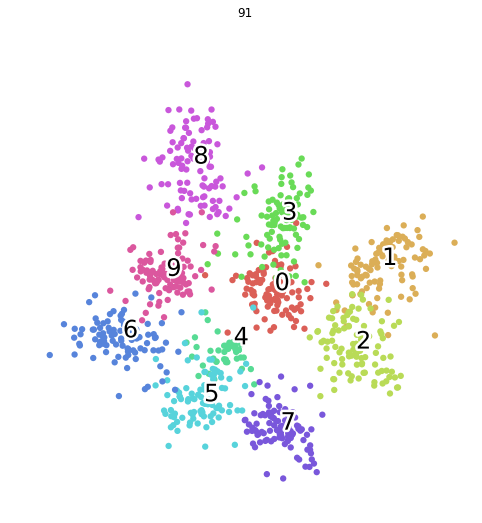

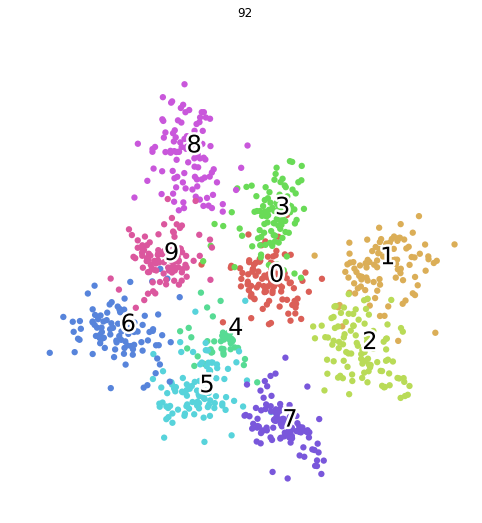

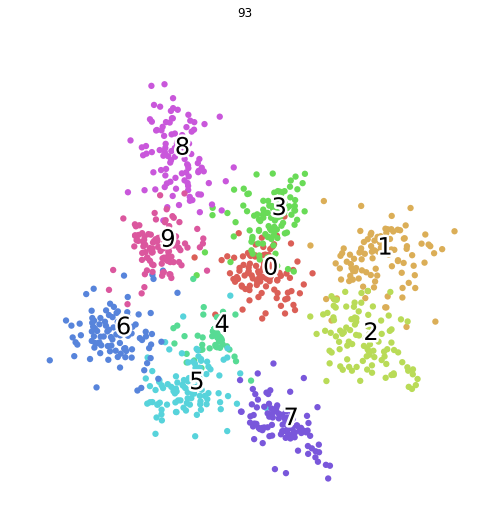

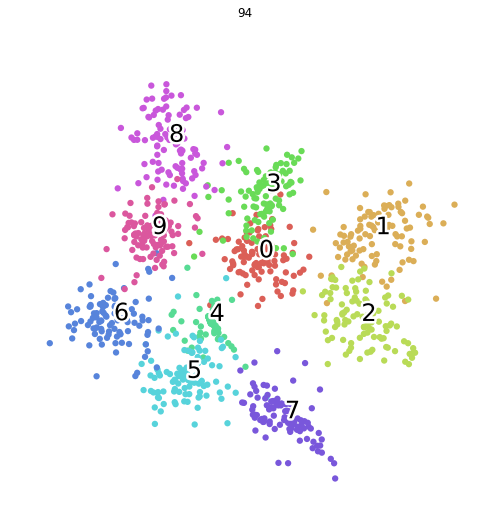

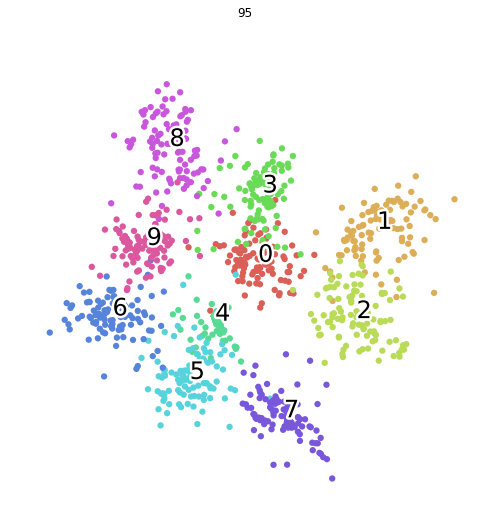

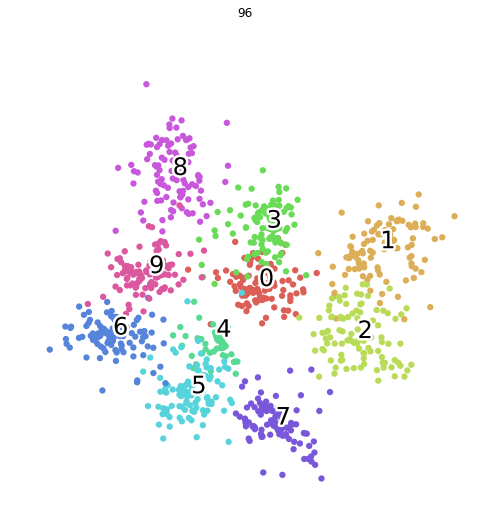

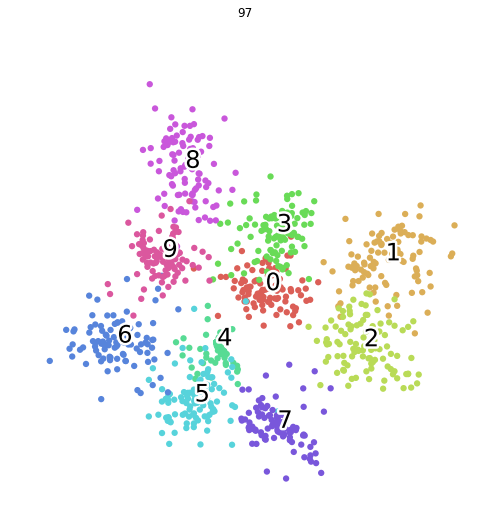

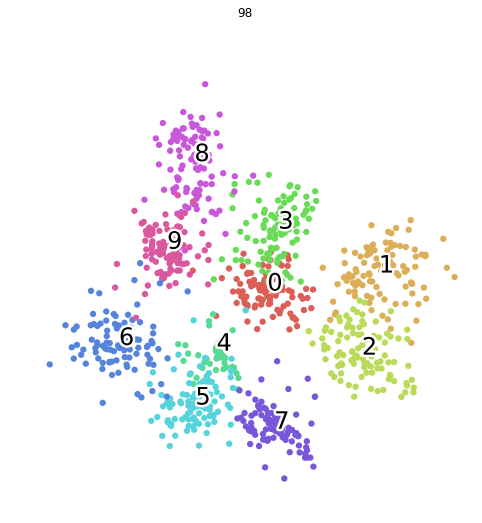

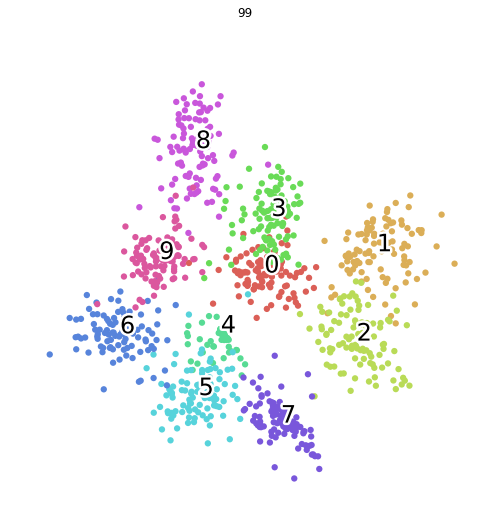

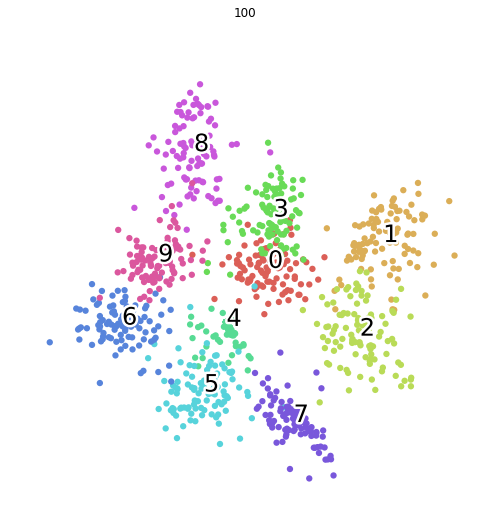

In [12]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss, pos_triplet, valid_triplet = batch_all_triplet_loss(labels, outputs, margin=0.5, squared=True)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2 == 0:
            print("At epoches = {}, i = {}, loss = {}, trainable_triplet = {}, total_triplets = {}".format(epoch, i, loss, pos_triplet, valid_triplet))
    epoch_loss = running_loss / trainloader.batch_size
    
    outputs = model(x_train)
    scatter(outputs.cpu().detach().numpy(), ar_y, epoch+1)
    
    print("epoch_loss = {}".format(epoch_loss))
print('Finished Training')